Torch: 2.8.0+cu126
Torchaudio: 2.8.0+cu126
Device: cuda
[19, 16, 23, 23, 26, 11, 24, 36, 11, 25, 12, 24, 16, 11, 20, 30, 11, 24, 20, 25, 36, 16, 26, 22, 11, 22, 20, 24]
tensor([[19, 16, 23, 23, 26, 11, 24, 36, 11, 25, 12, 24, 16, 11, 20, 30, 11, 24,
         20, 25, 36, 16, 26, 22, 11, 22, 20, 24]])
tensor([28], dtype=torch.int32)
['h', 'e', 'l', 'l', 'o', ' ', 'm', 'y', ' ', 'n', 'a', 'm', 'e', ' ', 'i', 's', ' ', 'm', 'i', 'n', 'y', 'e', 'o', 'k', ' ', 'k', 'i', 'm']

=== WaveRNN 방식 ===


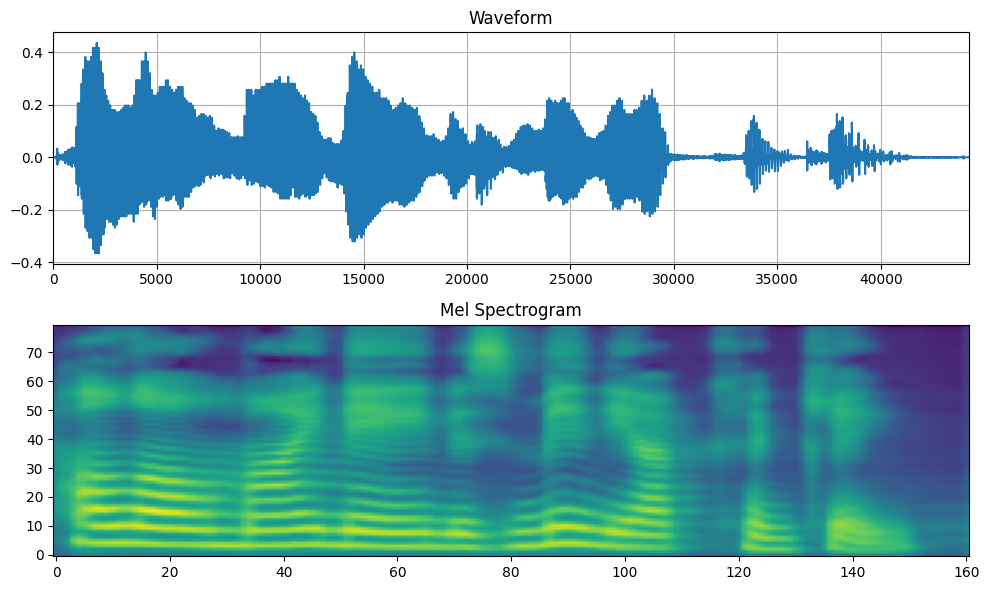


=== Griffin-Lim 방식 ===


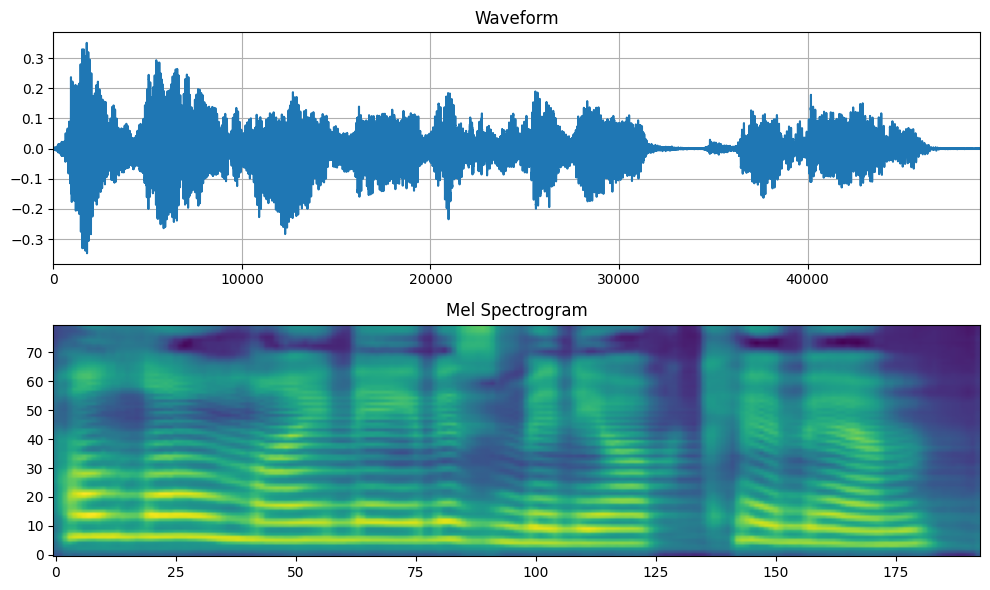


=== WaveGlow 방식 ===


Using cache found in C:\Users\zkdlw/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


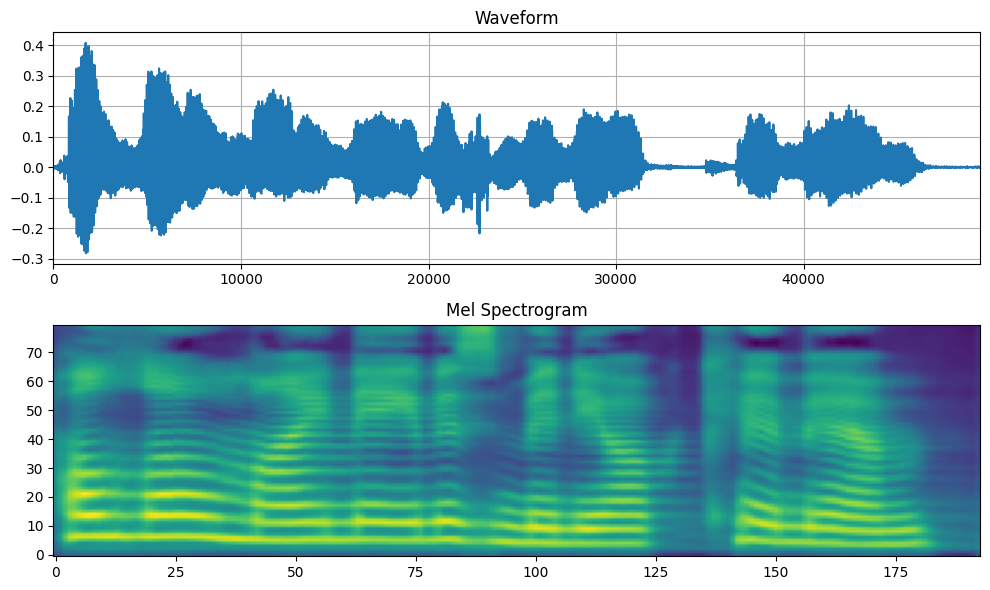

In [4]:
import torch
import torchaudio
import IPython
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# 0️⃣ 환경 설정
# ----------------------------------------------------------------------
torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Torch:", torch.__version__)
print("Torchaudio:", torchaudio.__version__)
print("Device:", device)

# ----------------------------------------------------------------------
# 1️⃣ 텍스트 전처리 도우미 함수
# ----------------------------------------------------------------------
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)

def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]

# ----------------------------------------------------------------------
# 2️⃣ 시각화 + 오디오 출력 함수
# ----------------------------------------------------------------------
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10, 6))
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax1.set_title("Waveform")
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    ax2.set_title("Mel Spectrogram")
    plt.tight_layout()
    plt.show()

    return IPython.display.Audio(waveforms[0].numpy(), rate=sample_rate)

# ----------------------------------------------------------------------
# 3️⃣ 텍스트 준비
# ----------------------------------------------------------------------
text = "Hello my name is Minyeok Kim"

print(text_to_sequence(text))

processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()
processed, lengths = processor(text)
print(processed)
print(lengths)
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

# ----------------------------------------------------------------------
# 4️⃣ WaveRNN 방식
# ----------------------------------------------------------------------
print("\n=== WaveRNN 방식 ===")
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed, lengths = processed.to(device), lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

IPython.display.display(plot(waveforms, spec, vocoder.sample_rate))

# ----------------------------------------------------------------------
# 5️⃣ Griffin-Lim 방식
# ----------------------------------------------------------------------
print("\n=== Griffin-Lim 방식 ===")
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed, lengths = processed.to(device), lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

# Griffin-Lim에는 sample_rate 속성이 없음 → 22050 지정
IPython.display.display(plot(waveforms, spec, 22050))

# ----------------------------------------------------------------------
# 6️⃣ WaveGlow 방식
# ----------------------------------------------------------------------
print("\n=== WaveGlow 방식 ===")
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)

checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",
    map_location=device,
)

state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

waveforms = waveforms.cpu().detach()
IPython.display.display(plot(waveforms, spec, 22050))
